In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import face_alignment

from preprocess import calibrate, normalize, undistort_image
from eve import EVE

# Pipeline for preprocessing as per EVE dataset

### Preprocessing steps:

1) intrinsic matrix calibration using opencv and ChArUco board [5]
2) extrinsic camera calibration using mirrors [1]
3) undistort the frames
4) detect face 
5) detect face-region landmarks (use face_alignment and blazeface)
6) perform 3D morphable model (3DMM) to 3D landmarks [2]
7) apply 'data normalization' for yielding eye patches [3, 4] under assumptions:
   - virtual camera is located 60cm away from the gaze origin
   - focal length of 1800mm


[1] https://www.jstage.jst.go.jp/article/ipsjtcva/8/0/8_11/_pdf/-char/en

[2] https://openresearch.surrey.ac.uk/discovery/delivery/44SUR_INST:ResearchRepository/12139198320002346#13140605970002346

[3] https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Sugano_Learning-by-Synthesis_for_Appearance-based_2014_CVPR_paper.pdf

[4] https://www.perceptualui.org/publications/zhang18_etra.pdf

[5] https://docs.opencv.org/4.5.2/dc/dbb/tutorial_py_calibration.html

In [2]:
np.set_printoptions(suppress=True)

In [3]:
images = [cv2.resize(cv2.imread(i), (1920, 1080))
          for i in glob.glob('./data/*.jpg')]

In [4]:
ret, mtx, dist, rvecs, tvecs = calibrate(images)

In [5]:
img = images[5]

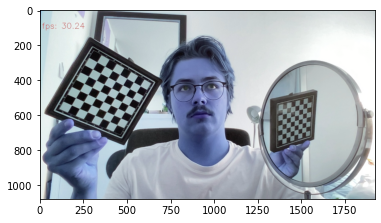

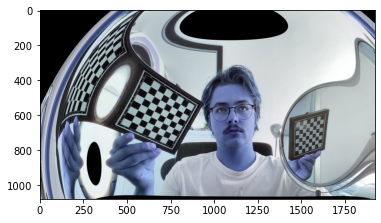

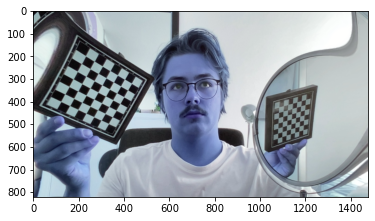

In [6]:
img = undistort_image(img, mtx, dist)

In [7]:
fa2d = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,
                                    flip_input=False,
                                    device='cpu',
                                    face_detector='blazeface')

landmark indices:
- corner left left: 36
- corner left right: 39
- corner right left: 42
- corner right right: 45
- mouth left: 48
- mouth right: 54

In [8]:
[preds] = fa2d.get_landmarks(img)

/Users/piotrostrowski/miniforge3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-q81c20j3/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
landmarks = [preds[36], preds[39], preds[42], preds[45], preds[48], preds[54]]

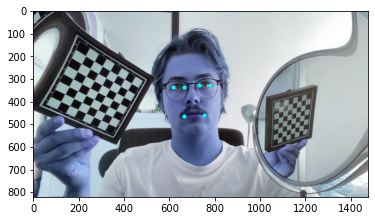

In [10]:
_img = img.copy()
plt.imshow(_img)
for i in landmarks:
    plt.scatter(i[0], i[1], color='cyan', marker='.')

In [11]:
gc = np.array([-127.790719, 4.621111, -12.025310])  # 3D gaze taraget position

In [12]:
head_R, [
    [left_eye_patch, left_hr_norm, left_gc_normalized, left_R, left_W],
    [right_eye_patch, right_hr_norm, right_gc_normalized, right_R, right_W]
] = head_R, data = normalize(img, mtx, dist, landmarks, gc)

(128, 256)

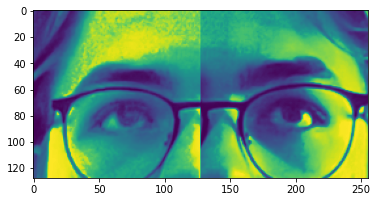

In [13]:
eyes_cat = np.concatenate((left_eye_patch, right_eye_patch), axis=1)
plt.imshow(eyes_cat)
eyes_cat.shape

In [14]:
left_R, right_R

(array([[ 0.97893696, -0.10913434,  0.172546  ],
        [ 0.04973973,  0.94716162,  0.31687666],
        [-0.19801107, -0.30161989,  0.93263983]]),
 array([[ 0.99142359, -0.08521353,  0.09908539],
        [ 0.04973973,  0.94716162,  0.31687666],
        [-0.12085205, -0.30923052,  0.94327688]]))

In [15]:
left_W

array([[   0.64154127,   -0.08247598, -329.15387471],
       [   0.02673854,    0.6238401 , -164.56531163],
       [  -0.00009643,   -0.00014845,    0.86500718]])

In [16]:
left_gc_normalized

array([[-0.15089544],
       [-0.00684271],
       [-0.98852605]])

In [17]:
from utils import get_sample_input

In [18]:
inp = get_sample_input()

origin of gaze ({left, right, face}_o) is yet to be determined

camera transformation should be obtainable from the rvec and tvec from data normalization

In [19]:
inp['left_R'][:, 0], inp['right_R'][:, 0]

(tensor([[[ 0.9993, -0.0105, -0.0354],
          [ 0.0147,  0.9927,  0.1198],
          [ 0.0339, -0.1202,  0.9922]]]),
 tensor([[[ 0.9980, -0.0219,  0.0590],
          [ 0.0147,  0.9926,  0.1205],
          [-0.0613, -0.1194,  0.9910]]]))

In [20]:
left_R, right_R

(array([[ 0.97893696, -0.10913434,  0.172546  ],
        [ 0.04973973,  0.94716162,  0.31687666],
        [-0.19801107, -0.30161989,  0.93263983]]),
 array([[ 0.99142359, -0.08521353,  0.09908539],
        [ 0.04973973,  0.94716162,  0.31687666],
        [-0.12085205, -0.30923052,  0.94327688]]))

left_R as well as right right_R are both there

In [21]:
inp['head_R'][:, 0]

tensor([[[ 0.9995,  0.0270, -0.0140],
         [-0.0178,  0.8929,  0.4499],
         [ 0.0247, -0.4494,  0.8930]]])

In [22]:
head_R

array([[ 0.99321286,  0.05590847, -0.10199242],
       [-0.08030653,  0.9639635 , -0.2536242 ],
       [ 0.08413723,  0.26009347,  0.96191076]])

head_R is also there

In [23]:
inp['left_h'][:, 0]

tensor([[ 0.5864, -0.0606]])

In [24]:
left_hr_norm

array([[-0.05950211],
       [ 0.09408642],
       [ 0.00280207]])

In [25]:
from normalize_data import estimateHeadPose
import scipy.io as sio

In [26]:
face = sio.loadmat('./faceModelGeneric.mat')['model']
face_pts = face.T.reshape(face.shape[1], 1, 3)

In [27]:
estimateHeadPose(np.array(landmarks), face_pts, mtx, dist)

(array([[ 0.26037975],
        [-0.09434052],
        [-0.06904109]]),
 array([[-135.15648918],
        [-258.77921993],
        [ 794.72053567]]))

Im also not sure where left_h comes from...

aside from that millimeters per pixel can be found in the display specifications, so can pixels per millimeter

eye patches as well as timestamps we got, same with screen frame and stamps

In [47]:
ret, rvec, tvec = cv2.solvePnP(face_pts,np.array(landmarks), mtx, dist, flags=cv2.SOLVEPNP_SQPNP)

In [48]:
rotation_m, _ = cv2.Rodrigues(rvec)
extrinsic_matrix = np.hstack([rotation_m, tvec])
extrinsic_matrix = np.vstack([extrinsic_matrix, [0, 0, 0, 1]])

In [49]:
extrinsic_matrix

array([[   0.96106481,    0.04613958,    0.2724437 , -123.5035078 ],
       [   0.02884393,    0.96382326,   -0.26497689, -237.66292317],
       [  -0.2748135 ,    0.26251831,    0.92496577,  724.0253216 ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [54]:
inp['camera_transformation'][:, 0].numpy()

array([[[  -0.9998209 ,    0.01386724,    0.01287777,  265.4817    ],
        [   0.0088855 ,    0.9447991 ,   -0.32752967, -421.44687   ],
        [  -0.01670884,   -0.32735658,   -0.9447531 ,  149.0165    ],
        [   0.        ,    0.        ,    0.        ,    1.        ]]],
      dtype=float32)

so there remains gaze origin and the px stuff

provided that the above matrix is right as the values seem to be of different singn